In [1]:
modelPath = "Clickbait"
checkpoint = "microsoft/Multilingual-MiniLM-L12-H384"
                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
problem_type =  "single_label_classification" # Valeurs possibles : "regression", "single_label_classification", "multi_label_classification"
num_labels = 2                                # 5
dataCuratedPath = "Data/Curated"              # Données pour tous les sites du 1er janvier 2021 au 30 avril 2021
                                              # Données juste pour le site "Actualités, trucs et astuces" entre le 1er mai et le 31 juillet 2021.
                                              # Les colonnes sont les suivantes, séparées par des ";" :
                                              #    Page name;Title;Publish time;People Reached;Link Clicks
LCfraction = 'truthMean'
inputColumn = 'postText'
removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.2                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
   checkpoint,
   problem_type=problem_type, # on pourra enlever ce paramètre si ca marche plus
   num_labels = num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elemen

In [5]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Bonjour, comment ça va ?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Bonjour, comment ça va ?")))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour, comment ça va ?")))
print(tokenizer.decode(tokenizer.encode("Bonjour, comment ça va ?")))

{'input_ids': [0, 84602, 4, 6868, 3244, 307, 705, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
['▁Bonjour', ',', '▁comment', '▁ça', '▁va', '▁?']
[0, 84602, 4, 6868, 3244, 307, 705, 2]
[84602, 4, 6868, 3244, 307, 705]
['<s>', '▁Bonjour', ',', '▁comment', '▁ça', '▁va', '▁?', '</s>']
<s> Bonjour, comment ça va?</s>


In [6]:
import datasets as ds

In [7]:
curated = ds.load_from_disk(dataCuratedPath)

In [32]:
curated

Dataset({
    features: ['postText', 'id', 'targetTitle', 'targetDescription', 'truthMean'],
    num_rows: 19538
})

In [8]:
curated.to_pandas()

,postText,id,targetTitle,targetDescription,truthMean
0,UK’s response to modern slavery leaving victim...,858462320779026432,‘Inexcusable’ failures in UK’s response to mod...,“Inexcusable” failures in the UK’s system for ...,1.000000
1,this is good,858421020331560960,Donald Trump Appoints Pro-Life Advocate as Ass...,President Donald Trump has appointed pro-life ...,0.133333
2,"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,The ‘forgotten’ Trump roast: Relive his brutal...,President Trump won't be at this year's White ...,0.400000
3,Meet the happiest #dog in the world!,858323428260139008,"Meet The Happiest Dog In The World, Maru The H...","The article is about Maru, a husky dog who has...",0.266667
4,Tokyo's subway is shut down amid fears over an...,858283602626347008,Tokyo's subway is shut down amid fears over an...,"The temporary suspension, which lasted ten min...",0.000000
...,...,...,...,...,...
19533,Brazil soccer team and pilot's final interview...,804250183642976256,"NBC News Video See Brazil Soccer Team, Pilot’s...",NBC News,0.133333
19534,😱😱😱😱😱😱😱😱😱😱😱😱😱😱,804156272086020096,Politico Scoop: Eric Trump Killed Two Deer,Politico Scoop: Eric Trump Killed Two Deer,0.066667
19535,Frenchs Forest high school may have to make wa...,804149798651588608,Frenchs Forest high school may relocate to mak...,The Forest High School on Sydney's northern be...,0.333333
19536,Oh Jeff… #bruh,804134698729385984,Los Angeles Rams Jeff Fisher May Think Danny W...,"Los Angeles Rams news, rumors, scores, schedul...",0.733333


In [9]:
if modelPath == "ClickbaitTest":
    # La il va falloir filtrer pour Actualités, trucs et astuces
    import re
    pageName = 'Actualités, trucs et astuces'
    p = re.compile(pageName)
    curated=curated.filter(lambda x : p.match(x["Page name"]))

In [10]:
longueur= len(curated)
longueur

19538

In [11]:
trie=sorted(curated[LCfraction])

In [12]:
import matplotlib.pyplot as plt

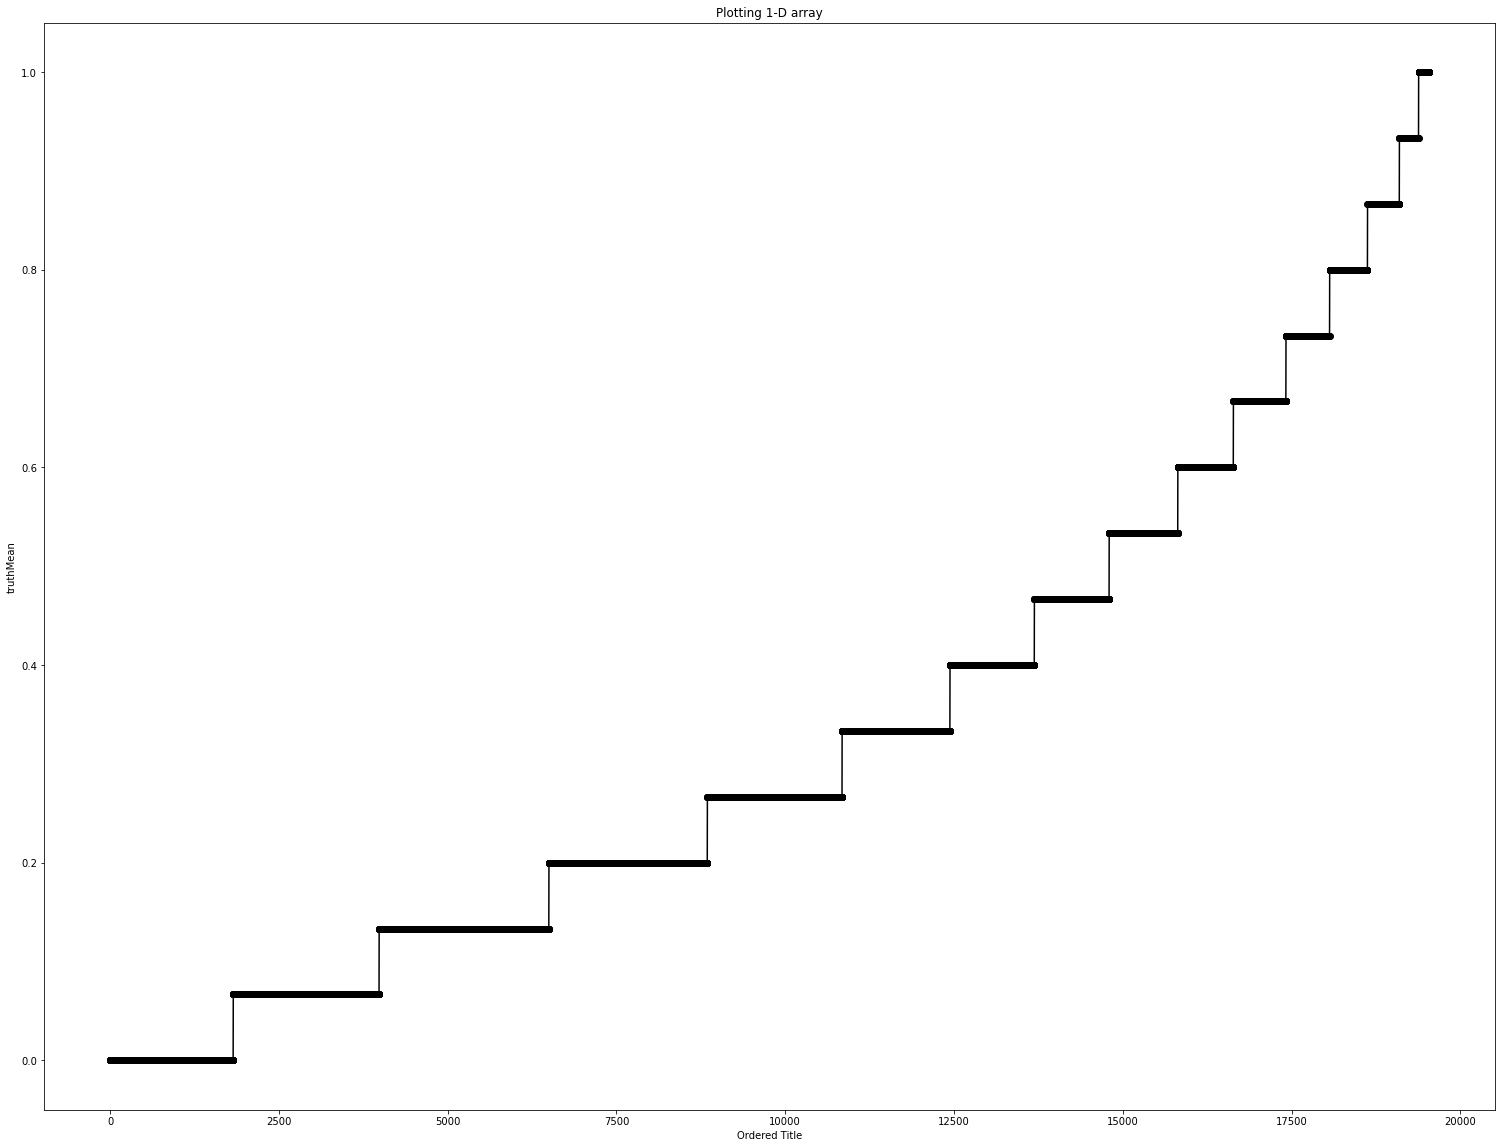

In [13]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [14]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[0.26666666664]

In [15]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            #   str(int(sample[LCfraction])),
            #padding=True,
            #truncation=True,
            #max_length=30
            )
    fraction = sample[LCfraction]
    
    if num_labels == 1:
        tokenized_sample["label"] = fraction
    else:
        tokenized_sample["label"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    
    # print( fraction, tokenized_sample["input_ids"], tokenized_sample["label"], sample[inputColumn])
    
    return tokenized_sample

In [16]:
tokenized_curated = curated.map(tokenize) #, batched=True)

Loading cached processed dataset at Data/Curated\cache-8bb57be11822c736.arrow


In [17]:
tokenized_curated.to_pandas().describe()

,id,truthMean,label
count,1.953800e+04,19538.000000,19538.000000
mean,8.314393e+17,0.324530,0.547241
std,1.569423e+16,0.252824,0.497776
min,8.041138e+17,0.000000,0.000000
25%,8.178346e+17,0.133333,0.000000
50%,8.316563e+17,0.266667,1.000000
75%,8.449404e+17,0.466667,1.000000
max,8.584642e+17,1.000000,1.000000


In [18]:
print(tokenized_curated[0:3])

{'postText': ['UK’s response to modern slavery leaving victims destitute while abusers go free', 'this is good', 'The "forgotten" Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club'], 'id': [858462320779026432, 858421020331560960, 858368123753435136], 'targetTitle': ['‘Inexcusable’ failures in UK’s response to modern slavery leaving victims destitute while abusers go free, report warns', 'Donald Trump Appoints Pro-Life Advocate as Assistant Secretary of HHS for Public Affairs', 'The ‘forgotten’ Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club'], 'targetDescription': ['“Inexcusable” failures in the UK’s system for dealing with modern slavery are\xa0leaving victims reduced to destitution while their abusers go free because they are not adequately supported to testify against them, an alarming report has warned.', 'President Donald Trump has appointed pro-life advocate and former president of Americans United for Life Dr. Charmaine Yoest to 

In [19]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [20]:
tokenized_curated2['train'].to_pandas()

,postText,id,targetTitle,targetDescription,truthMean,input_ids,attention_mask,label
0,"""Yes, I pelted stones yesterday. But that's no...",857124599988965376,21-Year-Old KashmirI Girl Who Pelted Stones At...,21-Year-Old Kashmir Girl Who Pelted Stones At ...,0.733333,"[0, 44, 91480, 4, 87, 4203, 3674, 3474, 1444, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,A gallery of Miss Golden Globe: Looking back a...,818267827064938496,A Gallery of Miss Golden Globe: Looking Back a...,"No doubt about it, Miss Golden Globe is the mo...",0.800000,"[0, 62, 6, 151570, 111, 16771, 43114, 162097, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,What a world without Carrie Fisher means for t...,813846749597016064,What a world without Carrie Fisher means for t...,We will see Leia on screen one more time.,0.400000,"[0, 4865, 10, 8999, 15490, 3980, 5056, 169247,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
3,South Korea Sewol ferry disaster: Human remain...,846659966475882496,South Korea Sewol ferry disaster: Human remain...,"Officials say bones have been found, as the re...",0.800000,"[0, 25134, 26320, 503, 25400, 1592, 1294, 6392...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
4,"Big Sean has revealed his fourth album ""I Deci...",812243109111361536,"Big Sean Reveals Fourth Album 'I Decided,' Unl...","Sean tweeted the release date, artwork and sha...",0.000000,"[0, 14195, 82421, 1556, 122273, 297, 1919, 227...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...,...,...,...,...,...
1948,"""So you want to preserve the liberal internati...",811323572635529216,So you want to preserve the liberal internatio...,As states retreat from preserving the U.S.-cre...,0.333333,"[0, 44, 8912, 398, 3444, 47, 479, 86687, 70, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1949,Awww.,822910938621902848,"China Tightens Censorship, Bans Livestreaming ...",Ahead of the inauguration of Donald Trump as t...,0.600000,"[0, 62, 1574, 5, 2]","[1, 1, 1, 1, 1]",1
1950,Donald Trump told a mostly-white PA crowd to t...,809631087681011712,Donald Trump Thanks African-Americans Who 'Did...,Trump said that African-Americans were &quot;s...,0.133333,"[0, 16692, 5879, 30745, 10, 153161, 9, 148477,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1951,#Cabinet documents detail resistance to allowi...,815207640728936448,Cabinet documents detail resistance to allowin...,The Keating Government was warned that allowin...,0.066667,"[0, 468, 441, 14508, 1179, 60525, 22443, 39746...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [21]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [22]:
tokenized_curated4 = tokenized_curated3

In [23]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 1953
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 17585
    })
})

In [24]:
#tokenized_curated4.set_format("torch")

In [25]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 8,
                                  optim= 'adamw_torch',
                                  learning_rate=learning_rate,
                                  # learning_rate = 5e-4,
                                  weight_decay=weight_decay,
                                  push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

In [27]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [28]:
print(tokenized_curated4["train"][0:20])

{'input_ids': [[0, 44, 91480, 4, 87, 4203, 3674, 3474, 1444, 131101, 5, 4966, 450, 25, 7, 959, 2367, 87, 3444, 47, 54, 1242, 468, 4332, 16711, 18, 6, 118280, 2], [0, 62, 6, 151570, 111, 16771, 43114, 162097, 12, 157268, 4420, 99, 70, 170277, 4, 70, 160608, 13, 4, 136, 70, 67199, 7, 468, 122558, 33, 54285, 90, 2], [0, 4865, 10, 8999, 15490, 3980, 5056, 169247, 26950, 100, 70, 4612, 34210, 14997, 13, 2], [0, 25134, 26320, 503, 25400, 1592, 1294, 6392, 1515, 12, 28076, 47143, 7, 14037, 2], [0, 14195, 82421, 1556, 122273, 297, 1919, 22759, 927, 7156, 44, 568, 49132, 48141, 4, 58, 136, 51, 14507, 67175, 3525, 44, 9083, 3132, 58, 2], [0, 192429, 167540, 26156, 5281, 10, 242, 10770, 214, 47, 21629, 25, 40, 37631, 4, 136, 30309, 72856, 2363, 121584, 7086, 7, 5, 2], [0, 51661, 329, 35262, 4223, 65922, 7, 16692, 5879, 25, 7, 57553, 47, 6, 130687, 90791, 7, 98, 49002, 2], [0, 10160, 32, 2], [0, 581, 17955, 2795, 35691, 7, 4420, 13416, 111, 41550, 5458, 6431, 44, 2271, 20549, 2320, 58, 2], [0, 243

In [29]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  # callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [30]:
# faire la boucle avec le trainer pytorch
# %pdb
trainer.train()

***** Running training *****
  Num examples = 1953
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1960


Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.689014,0.546716,0.706938
100,No log,0.689556,0.546716,0.706938
150,No log,0.689811,0.546716,0.706938
200,No log,0.688872,0.546716,0.706938
250,No log,0.690372,0.546716,0.706938
300,No log,0.688853,0.546716,0.706938
350,No log,0.688878,0.546716,0.706938


***** Running Evaluation *****
  Num examples = 17585
  Batch size = 8
***** Running Evaluation *****
  Num examples = 17585
  Batch size = 8
***** Running Evaluation *****
  Num examples = 17585
  Batch size = 8
***** Running Evaluation *****
  Num examples = 17585
  Batch size = 8
***** Running Evaluation *****
  Num examples = 17585
  Batch size = 8
***** Running Evaluation *****
  Num examples = 17585
  Batch size = 8
***** Running Evaluation *****
  Num examples = 17585
  Batch size = 8
***** Running Evaluation *****
  Num examples = 17585
  Batch size = 8


KeyboardInterrupt: 

In [87]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 16
  Batch size = 8


{'eval_loss': 0.43070757389068604,
 'eval_accuracy': 0.8125,
 'eval_f1': 0.8235294117647058,
 'eval_runtime': 0.0941,
 'eval_samples_per_second': 170.12,
 'eval_steps_per_second': 21.265,
 'epoch': 8.0}

In [98]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "test" #  "train" # "test"

In [99]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated4[overfitting])

***** Running Prediction *****
  Num examples = 16
  Batch size = 8


In [100]:
predictions.predictions

array([[ 1.0825515 , -1.261397  ],
       [ 0.16840985, -0.17182237],
       [ 1.0844158 , -1.2639939 ],
       [-1.0910052 ,  1.2826365 ],
       [-1.0903685 ,  1.2806336 ],
       [ 1.0841495 , -1.2615179 ],
       [-1.0897197 ,  1.2802064 ],
       [-1.0307432 ,  1.2115184 ],
       [-1.0845279 ,  1.2736262 ],
       [ 1.0609885 , -1.2291647 ],
       [ 1.0843325 , -1.262958  ],
       [ 1.0833747 , -1.2612356 ],
       [ 1.0854067 , -1.2649003 ],
       [-1.089214  ,  1.2787708 ],
       [ 1.077905  , -1.254181  ],
       [-1.0848985 ,  1.2747905 ]], dtype=float32)

In [101]:
predictions.metrics

{'test_loss': 0.43070757389068604,
 'test_accuracy': 0.8125,
 'test_f1': 0.8235294117647058,
 'test_runtime': 0.0844,
 'test_samples_per_second': 189.484,
 'test_steps_per_second': 23.685}

In [102]:
tct = tokenized_curated2[overfitting].to_pandas()

In [103]:
if num_labels == 1:
    tct["labelC"] = predictions.predictions
else:
    tct["labelC"] = np.argmax(predictions.predictions, axis=1)   

In [104]:
tct = tct.sort_values(LCfraction)

In [105]:
palette = ["r", "g", "b", "c", "m"]

In [106]:
if num_labels == 1:
    color = [val for val in tct["labelC"]]
else:
    color = [palette[val] for val in tct["labelC"]]

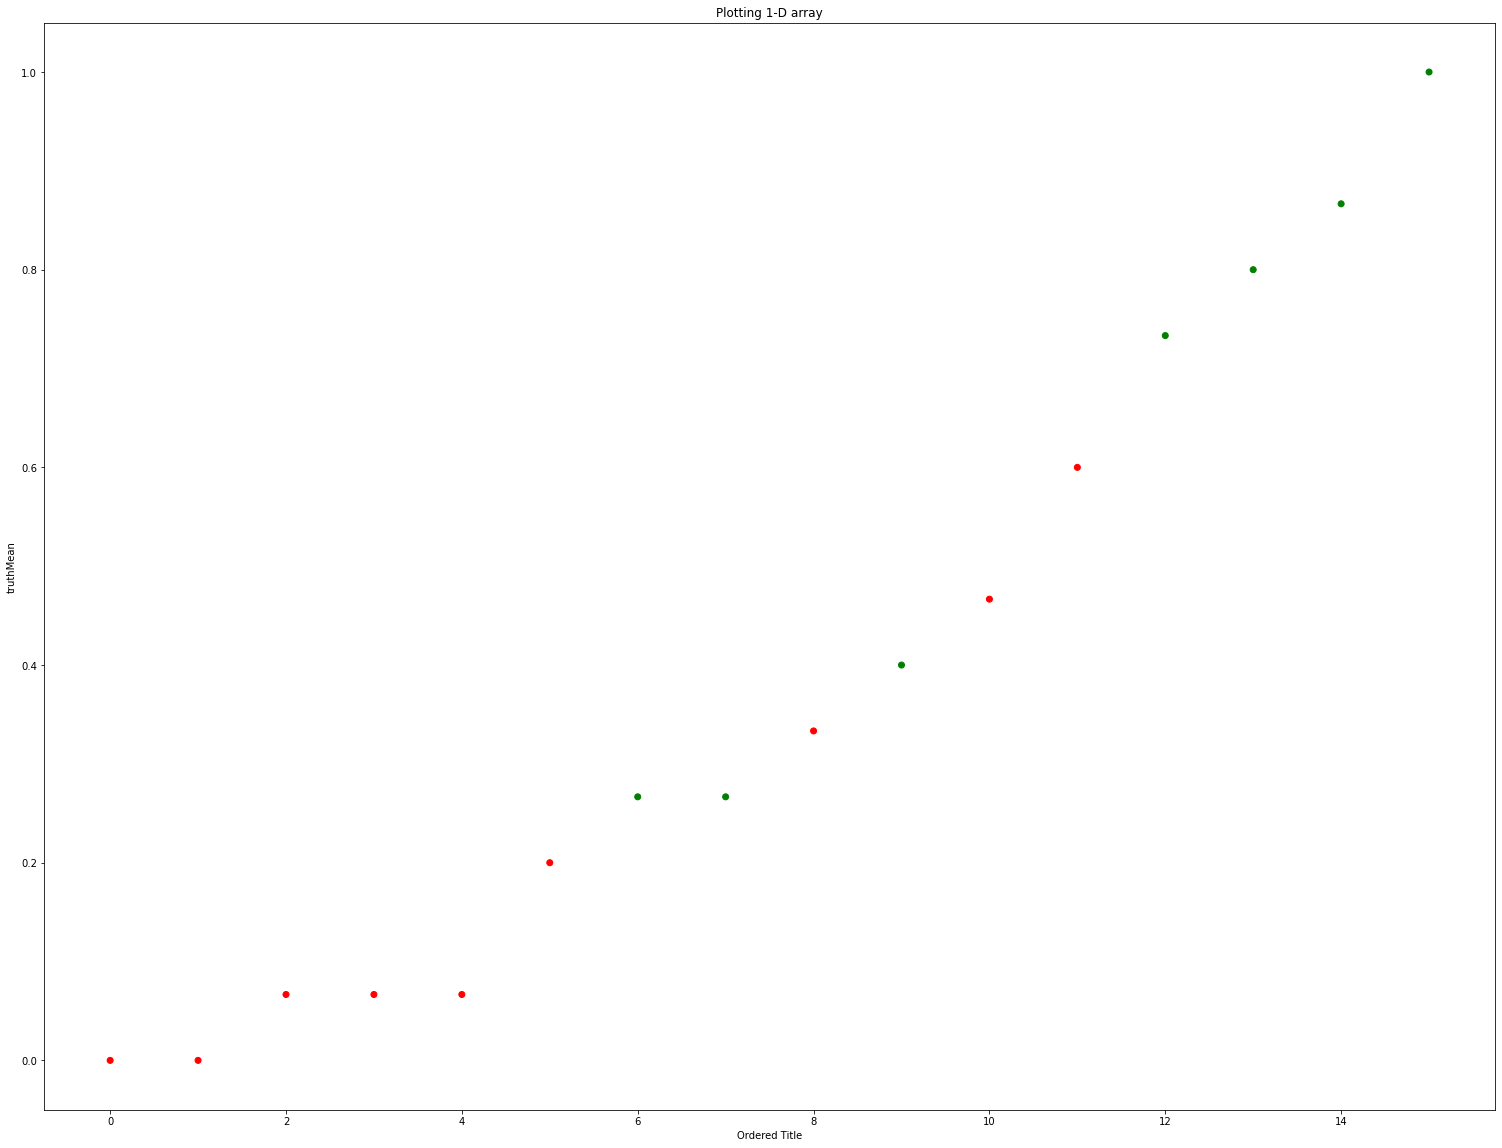

In [107]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction) #LCfraction
x = np.array(range(0, tct.shape[0]))
y = tct[LCfraction]
plt.scatter(x, y, c = color, marker = "o", label = "Array elements")

In [108]:
tct

,postText,id,targetTitle,targetDescription,truthMean,input_ids,attention_mask,label,labelC
11,One portion of the Trump trade is alive and well,858403549478301696,Investors are loving the champion of the Trump...,The smallest companies in the US market have g...,0.000000,"[0, 6561, 126826, 111, 70, 5879, 52350, 83, 92...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,0
14,An Indian woman explores an NRA convention,858317450017992704,From Gandhi to guns: An Indian woman explores ...,Guns are not a part of the culture of my homel...,0.000000,"[0, 893, 42878, 46667, 88898, 7, 142, 541, 122...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,0
0,Facts that will be truly upsetting to '90s girls,858464162594172928,Facts That Will Be Truly Upsetting To '90s Girls,,0.066667,"[0, 132640, 7, 450, 1221, 186, 87607, 1257, 89...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,0
5,Sunderland relegation ‘my worst day in footbal...,858387587987365888,Sunderland relegation ‘my worst day in footbal...,David Moyes experienced the ‘worst day’ of his...,0.066667,"[0, 79326, 53303, 47130, 125682, 204, 1176, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0
12,"Will Anthony Joshua thrill 90,000 of his count...",858382080941727744,Predictions: Who wins Anthony Joshua vs. Wladi...,Heavyweight world titleholder Anthony Joshua f...,0.066667,"[0, 20255, 94825, 184311, 6, 68332, 1181, 2510...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0
2,Hacker releases new episodes of 'Orange Is the...,858439565199249408,Hacker Releases New Episodes of 'Orange Is the...,The hacker who claims to have stolen the upcom...,0.200000,"[0, 52922, 56, 54452, 7, 3525, 50094, 7, 111, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0
7,"""Giant hurricane"" on Saturn: See the first ima...",858301853855080448,"""Giant hurricane"" on Saturn: First images from...",NASA&#039;s Cassini spacecraft snapped a view ...,0.266667,"[0, 44, 724, 26865, 3587, 12056, 86, 58, 98, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1
4,Almost 20% of Pres. Trump's first 100 days wer...,858450499921731584,President Trump's first 100 days 'by the numbe...,calvin has this,0.266667,"[0, 78289, 5510, 12719, 111, 20703, 5, 5879, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1
1,"If Republicans can’t get this lawmaker, Obamac...",858302188573085696,"If Republicans Can’t Get This Lawmaker, Obamac...",Representative Fred Upton helped guide dozens ...,0.333333,"[0, 4263, 131161, 7, 831, 26, 18, 2046, 903, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0
8,times are tough. should i turn off the heat a ...,858307544208605184,ESPN Layoffs at Leading Edge of the Coming ‘Sp...,ESPN Layoffs at Leading Edge of the Coming 'Sp...,0.400000,"[0, 20028, 621, 143033, 5, 5608, 17, 15504, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1


In [109]:
tct["labelC"].describe()

count    16.000000
mean      0.437500
std       0.512348
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: labelC, dtype: float64

In [110]:
tct.corr()

,id,truthMean,label,labelC
id,1.000000,0.159879,-0.213001,0.073121
truthMean,0.159879,1.000000,0.770341,0.652858
label,-0.213001,0.770341,1.000000,0.683130
labelC,0.073121,0.652858,0.683130,1.000000
